# Zonal Statistics


# Introduction to code
1. calculate zonal statistics for (indirect nutrient load/stream)WatershedPourPoints_LH.shp
2. Calculate Zonal statistics for (direct nutrient flux/coastal wetland corresponding watershed)wetland_connected_avg_inundation_NAD1983_Watershed
3. Subtract the values of flux that have overlap 

# Required Imports

In [2]:
### Reqiured Imports###
import pandas, os
import arcpy
from matplotlib import pyplot as plt
import pandas as pd

# Inputs

In [36]:

# Define the base paths
base_path = r'D:\Users\abolmaal\Arcgis\NASAOceanProject'
nutrient_flux_path = r'D:\Users\abolmaal\Arcgis\NASAOceanProject\Luwen_Nutrient'
coastal_watersheds_path = r'D:\Users\abolmaal\code\CoastalWatersheds'

# Define the input paths
inDB = os.path.join(base_path, 'GIS_layer', 'Streamwatershed')


# Nutrient flux rasters
inBYRaster_TN = os.path.join(nutrient_flux_path, 'TN_Annual_delTotal_header_kgcellday.tif')
inBYRaster_TP = os.path.join(nutrient_flux_path, 'TP_Annual_delTotal_header_kgcellday.tif')

# Define the input feature classes
inPourpoint = 'WatershedPourPoints_NAD1983'

inWatershed = os.path.join(inDB, 'PointWatershed_LH_NAD1983_NASA_Invasive.shp')

# Define coastal watersheds
inCW = os.path.join(coastal_watersheds_path, 'Erase_drainage')
inCoastalWatershed_low = os.path.join(coastal_watersheds_path, 'Erase_lake', 'CoastalWatershed_low_erase_lakedrain_LakeHuron.shp')
inCoastalWatershed_high = os.path.join(coastal_watersheds_path, 'Erase_lake', 'CoastalWatershed_high_erase_lakedrain_LakeHuron.shp')
inCoastalWatershed_avg = os.path.join(coastal_watersheds_path, 'Erase_lake', 'CoastalWatershed_avg_erase_lakedrain_LakeHuron.shp')
inCoastalWatershed_surge = os.path.join(coastal_watersheds_path, 'Erase_lake', 'CoastalWatershed_surge_erase_lakedrain_LakeHuron.shp')

# Output coastal feature
outTable = 'direct_coastal_N_P_wetland_loads'
outFeature = 'wetland_connected_avg_inundation_Albers'

# Environment settings
arcpy.env.overwriteOutput = True
arcpy.env.workspace = inDB

# Temporary files
tempZonal = 'temp_zonal_stats'

# Fields to calculate / Direct delivery to Watersheds
fieldDirectTN = 'WetLoad_TN_kgcelldaypersquarem'
fieldDirectTP = 'WetLoad_TP_kgcelldaypersquarem'

# Direct delivery to Coastal Watersheds
fieldCoastalTN_avg = 'CoastLoad_TN_kgcelldaypersquarem_avg'
fieldCoastalTP_avg = 'CoastLoad_TP_kgcelldaypersquarem_avg'

fieldCoastalTN_low = 'CoastLoad_TN_kgcelldaypersquarem_low'
fieldCoastalTP_low = 'CoastLoad_TP_kgcelldaypersquarem_low'

fieldCoastalTN_high = 'CoastLoad_TN_kgcelldaypersquarem_high'
fieldCoastalTP_high = 'CoastLoad_TP_kgcelldaypersquarem_high'

fieldCoastalTN_surge = 'CoastLoad_TN_kgcelldaypersquarem_surge'
fieldCoastalTP_surge = 'CoastLoad_TP_kgcelldaypersquarem_surge'


##############################################
fieldCoastalLimTN = 'CoastLoad_TN_lim_kg2'
fieldCoastalLimTP = 'CoastLoad_TP_lim_kg2'

# Ratios
fieldDirectRatio = 'WetLoad_TN_TP_ratio'
fieldCoastalRatio = 'CoastLoad_TN_TP_ratio'
fieldCoastalDirectRatioTN = 'Coast_Direct_ratio_TN'
fieldCoastalDirectRatioTP = 'Coast_Direct_ratio_TP'

# Field names
fieldpourpointTN = 'PourPoint_TN_kg'
fieldpourpointTP = 'PourPoint_TP_kg'


# Outputs

In [32]:
outDb = os.path.join(base_path, 'ZonalStats')

outFig = os.path.join(base_path, 'figures')


# Main Functions

## Direct NUtrint Load to Stream Watersheds

####  Bring in Streamwatershed into a pandas dataframe and get the specific columns


In [19]:
# Bring in Streamwatershed into a pandas dataframe and get the specific columns

dfWatershed = pandas.DataFrame(arcpy.da.TableToNumPyArray(os.path.join(inDB,inWatershed), ['Group_id', 'gridcode','Shape_Area']))

In [20]:
dfWatershed

,Group_id,gridcode,Shape_Area
0,0,17747,2.608193e+07
1,1,17741,6.915027e+07
2,2,26421,1.703711e+08
3,3,17746,9.425426e+07
4,4,17757,3.772995e+07
...,...,...,...
172,172,28211,3.169744e+03
173,173,28211,1.396735e+07
174,174,28161,7.877722e+06
175,175,28349,6.158370e+02


### Estimate Zonal statistics for StreamWatreshed
Bring in the nutrient flux rasters into a pandas dataframe and estimate the total nutrient load in the Streamwatershed

In [24]:
# 1- calculate the zonal statistics with arcpy for inWatershed using inBYRaster
inZonalTN_watershed = arcpy.sa.ZonalStatisticsAsTable(inWatershed, 'Group_id', inBYRaster_TN, 'SUM' ,'DATA')

# # bring in inWatershed and inZonalTN_watershed as pandas dataframes
dfZonalTN_watershed = pandas.DataFrame(arcpy.da.TableToNumPyArray(inZonalTN_watershed,
                                                                  ['Group_id', 'AREA','SUM']))
dfZonalTN_watershed

,Group_id,AREA,SUM
0,0,2.590560e+07,13.480809
1,1,6.922080e+07,51.878556
2,2,1.704240e+08,87.793043
3,3,9.429120e+07,54.996792
4,4,3.777120e+07,27.250568
...,...,...,...
140,170,1.959840e+07,63.984811
141,171,1.440000e+04,0.013980
142,173,1.376640e+07,23.636322
143,174,7.776000e+06,14.078233


In [ ]:
# Calculate the direct nutrient delivery to watersheds Kilograms per day per square meter:
dfZonalTN_watershed[fieldDirectTN] = dfZonalTN_watershed['SUM']/dfZonalTN_watershed['AREA']
dfZonalTN_watershed

,Group_id,AREA,SUM,WetLoad_TN_kgcelldaypersquarem
0,0,2.590560e+07,13.480809,5.203821e-07
1,1,6.922080e+07,51.878556,7.494648e-07
2,2,1.704240e+08,87.793043,5.151448e-07
3,3,9.429120e+07,54.996792,5.832654e-07
4,4,3.777120e+07,27.250568,7.214642e-07
...,...,...,...,...
140,170,1.959840e+07,63.984811,3.264798e-06
141,171,1.440000e+04,0.013980,9.708334e-07
142,173,1.376640e+07,23.636322,1.716957e-06
143,174,7.776000e+06,14.078233,1.810472e-06


In [26]:
inZonalTP_watershed = arcpy.sa.ZonalStatisticsAsTable(inWatershed, 'Group_id', inBYRaster_TP, 'SUM' ,'DATA')
dfZonalTP_watershed = pandas.DataFrame(arcpy.da.TableToNumPyArray(inZonalTP_watershed, 
                                                                   ['Group_id', 'AREA','SUM']))
# rcalculate Directec fieldDirectTP Kilograms per day per square meter:
dfZonalTP_watershed[fieldDirectTP] = dfZonalTP_watershed['SUM']/dfZonalTP_watershed['AREA']

dfZonalTP_watershed

,Group_id,AREA,SUM,WetLoad_TP_kgcelldaypersquarem
0,0,2.590560e+07,0.974675,3.762412e-08
1,1,6.922080e+07,2.000936,2.890657e-08
2,2,1.704240e+08,4.179389,2.452348e-08
3,3,9.429120e+07,3.598198,3.816048e-08
4,4,3.777120e+07,1.326998,3.513254e-08
...,...,...,...,...
140,170,1.959840e+07,4.299652,2.193879e-07
141,171,1.440000e+04,0.000563,3.911111e-08
142,173,1.376640e+07,4.034916,2.930988e-07
143,174,7.776000e+06,2.496025,3.209909e-07


###  Merge Streamwatershed for TN and TP

In [29]:
# merge dfWateshed with dfZonalTN_watershed where dfWateshed['Group_id'] = dfZonalTN_watershed['Group_id']
dfWatershed = dfWatershed.merge(dfZonalTP_watershed, left_on='Group_id', right_on='Group_id', how='inner')

In [30]:
# merge dfWateshed with dfZonalTN_watershed where dfWateshed['Group_id'] = dfZonalTN_watershed['Group_id']
dfWatershed = dfWatershed.merge(dfZonalTN_watershed, left_on='Group_id', right_on='Group_id', how='inner')
dfWatershed

,Group_id,gridcode,Shape_Area,AREA_x,SUM_x,WetLoad_TP_kgcelldaypersquarem,AREA_y,SUM_y,WetLoad_TN_kgcelldaypersquarem
0,0,17747,2.608193e+07,2.590560e+07,0.974675,3.762412e-08,2.590560e+07,13.480809,5.203821e-07
1,1,17741,6.915027e+07,6.922080e+07,2.000936,2.890657e-08,6.922080e+07,51.878556,7.494648e-07
2,2,26421,1.703711e+08,1.704240e+08,4.179389,2.452348e-08,1.704240e+08,87.793043,5.151448e-07
3,3,17746,9.425426e+07,9.429120e+07,3.598198,3.816048e-08,9.429120e+07,54.996792,5.832654e-07
4,4,17757,3.772995e+07,3.777120e+07,1.326998,3.513254e-08,3.777120e+07,27.250568,7.214642e-07
...,...,...,...,...,...,...,...,...,...
140,170,28148,1.961733e+07,1.959840e+07,4.299652,2.193879e-07,1.959840e+07,63.984811,3.264798e-06
141,171,28211,1.228467e+03,1.440000e+04,0.000563,3.911111e-08,1.440000e+04,0.013980,9.708334e-07
142,173,28211,1.396735e+07,1.376640e+07,4.034916,2.930988e-07,1.376640e+07,23.636322,1.716957e-06
143,174,28161,7.877722e+06,7.776000e+06,2.496025,3.209909e-07,7.776000e+06,14.078233,1.810472e-06


### Save stream watershed Nutrient load

In [45]:
# convert dfWatershed to a pandas dataframe
dfWatershed_pd = pd.DataFrame(dfWatershed)
# save dfWatershed_pd to a shape file in outDb with name outTable + '.shp'
dfWatershed_pd.to_csv(os.path.join(outDb, outTable + '.shp'))

In [34]:
# Save the dfWateshed to a csv file in the inDB directory with the name of Watresheds_total_N_P.csv
dfWatershed.to_csv(os.path.join(outDb, 'StreamWatresheds_total_N_P.csv'), index=False)

## 2- Zonal Statistics for coastal Wetlands watershed for Different Innundation

Calculate the zonal statistics with arcpy for inCoastawateshed using inBYRaster_TN, and inBYRaster_TP


In [49]:
#bring in the coastalwatreshed

dfCoastalWatershed_avg = pandas.DataFrame(arcpy.da.TableToNumPyArray(os.path.join(inCW,inCoastalWatershed_avg),
                                                                  ['coastal_id', 'gridcode','Shape_Area']))

dfCoastalWatershed_low = pandas.DataFrame(arcpy.da.TableToNumPyArray(os.path.join(inCW,inCoastalWatershed_low),
                                                                  ['coastal_id', 'gridcode','Shape_Area']))

dfCoastalWatershed_high = pandas.DataFrame(arcpy.da.TableToNumPyArray(os.path.join(inCW,inCoastalWatershed_high),
                                                                  ['coastal_id', 'gridcode','Shape_Area']))

dfCoastalWatershed_surge = pandas.DataFrame(arcpy.da.TableToNumPyArray(os.path.join(inCW,inCoastalWatershed_surge),
                                                                  ['coastal_id', 'gridcode','Shape_Area']))

#### Average Innundation

In [50]:
# 1- Calculate the zonal statistics with arcpy for inCoastalWatershed average inundation using inBYRaster_TN and inBYRaster_TP
inZonalTN_coastal_avg = arcpy.sa.ZonalStatisticsAsTable(inCoastalWatershed_avg, 'coastal_id', inBYRaster_TN, 'SUM' ,'DATA')
inZonalTP_coastal_avg = arcpy.sa.ZonalStatisticsAsTable(inCoastalWatershed_avg, 'coastal_id', inBYRaster_TP, 'SUM' ,'DATA')

# # bring in inCoastalWatershed and inZonalTN_coastal as pandas dataframes
dfZonalTN_coastal_avg = pandas.DataFrame(arcpy.da.TableToNumPyArray(inZonalTN_coastal_avg,
                                                                  ['coastal_id', 'AREA','SUM']))

dfZonalTP_coastal_avg = pandas.DataFrame(arcpy.da.TableToNumPyArray(inZonalTP_coastal_avg,
                                                                  ['coastal_id', 'AREA','SUM']))

In [51]:
# add a field to dfZonal_TN_coastal_avg called fieldCoastalTN_avg which is equal to SUM column divided by Shape_Area
dfZonalTN_coastal_avg[fieldCoastalTN_avg] = dfZonalTN_coastal_avg['SUM']/dfCoastalWatershed_avg['Shape_Area']

# add a field to dfZonal_TP_coastal_avg called fieldCoastalTP_avg which is equal to SUM column divided by Shape_Area
dfZonalTP_coastal_avg[fieldCoastalTP_avg] = dfZonalTP_coastal_avg['SUM']/dfCoastalWatershed_avg['Shape_Area']

In [52]:
# merge dfZonalTN_coastal_avg and dfZonalTP_coastal_avg with dfCoastalWatershed_avg
dfCoastalWatershed_avg = dfCoastalWatershed_avg.merge(dfZonalTN_coastal_avg, left_on='coastal_id', right_on='coastal_id', how='inner')
dfCoastalWatershed_avg = dfCoastalWatershed_avg.merge(dfZonalTP_coastal_avg, left_on='coastal_id', right_on='coastal_id', how='inner')

### High inundation 


In [53]:
# 1- Calculate the zonal statistics with arcpy for inCoastalWatershed High inundation using inBYRaster_TN and inBYRaster_TP
inZonalTN_coastal_high = arcpy.sa.ZonalStatisticsAsTable(inCoastalWatershed_high, 'coastal_id', inBYRaster_TN, 'SUM' ,'DATA')
inZonalTP_coastal_high = arcpy.sa.ZonalStatisticsAsTable(inCoastalWatershed_high, 'coastal_id', inBYRaster_TP, 'SUM' ,'DATA')

# # bring in inCoastalWatershed and inZonalTN_coastal as pandas dataframes
dfZonalTN_coastal_high = pandas.DataFrame(arcpy.da.TableToNumPyArray(inZonalTN_coastal_high,
                                                                  ['coastal_id', 'AREA','SUM']))

dfZonalTP_coastal_high = pandas.DataFrame(arcpy.da.TableToNumPyArray(inZonalTP_coastal_high,
                                                                  ['coastal_id', 'AREA','SUM']))

In [54]:
# add a field to dfZonal_TN_coastal_avg called fieldCoastalTN_high which is equal to SUM column divided by Shape_Area
dfZonalTN_coastal_high[fieldCoastalTN_high] = dfZonalTN_coastal_high['SUM']/dfCoastalWatershed_high['Shape_Area']

# add a field to dfZonal_TP_coastal_avg called fieldCoastalTP_avg which is equal to SUM column divided by Shape_Area
dfZonalTP_coastal_high[fieldCoastalTP_high] = dfZonalTP_coastal_high['SUM']/dfCoastalWatershed_high['Shape_Area']

In [55]:
# merge dfZonalTN_coastal_avg and dfZonalTP_coastal_avg with dfCoastalWatershed_high
dfCoastalWatershed_high = dfCoastalWatershed_high.merge(dfZonalTN_coastal_high, left_on='coastal_id', right_on='coastal_id', how='inner')
dfCoastalWatershed_high = dfCoastalWatershed_high.merge(dfZonalTP_coastal_high, left_on='coastal_id', right_on='coastal_id', how='inner')

### Low inundation


In [56]:
# 1- Calculate the zonal statistics with arcpy for inCoastalWatershed low inundation using inBYRaster_TN and inBYRaster_TP
inZonalTN_coastal_low = arcpy.sa.ZonalStatisticsAsTable(inCoastalWatershed_low, 'coastal_id', inBYRaster_TN, 'SUM' ,'DATA')
inZonalTP_coastal_low = arcpy.sa.ZonalStatisticsAsTable(inCoastalWatershed_low, 'coastal_id', inBYRaster_TP, 'SUM' ,'DATA')

# # bring in inCoastalWatershed and inZonalTN_coastal as pandas dataframes
dfZonalTN_coastal_low = pandas.DataFrame(arcpy.da.TableToNumPyArray(inZonalTN_coastal_low,
                                                                  ['coastal_id', 'AREA','SUM']))

dfZonalTP_coastal_low = pandas.DataFrame(arcpy.da.TableToNumPyArray(inZonalTP_coastal_low,
                                                                  ['coastal_id', 'AREA','SUM']))

In [57]:
# add a field to dfZonal_TN_coastal_avg called fieldCoastalTN_avg which is equal to SUM column divided by Shape_Area
dfZonalTN_coastal_low[fieldCoastalTN_low] = dfZonalTN_coastal_low['SUM']/dfCoastalWatershed_low['Shape_Area']

# add a field to dfZonal_TP_coastal_avg called fieldCoastalTP_avg which is equal to SUM column divided by Shape_Area
dfZonalTP_coastal_low[fieldCoastalTP_low] = dfZonalTP_coastal_low['SUM']/dfCoastalWatershed_low['Shape_Area']

In [58]:
# merge dfZonalTN_coastal_avg and dfZonalTP_coastal_avg with dfCoastalWatershed_avg
dfCoastalWatershed_low = dfCoastalWatershed_low.merge(dfZonalTN_coastal_low, left_on='coastal_id', right_on='coastal_id', how='inner')
dfCoastalWatershed_low = dfCoastalWatershed_low.merge(dfZonalTP_coastal_low, left_on='coastal_id', right_on='coastal_id', how='inner')

### Surge inundation


In [59]:
# 1- Calculate the zonal statistics with arcpy for inCoastalWatershed average inundation using inBYRaster_TN and inBYRaster_TP
inZonalTN_coastal_surge = arcpy.sa.ZonalStatisticsAsTable(inCoastalWatershed_surge, 'coastal_id', inBYRaster_TN, 'SUM' ,'DATA')
inZonalTP_coastal_surge = arcpy.sa.ZonalStatisticsAsTable(inCoastalWatershed_surge, 'coastal_id', inBYRaster_TP, 'SUM' ,'DATA')

# # bring in inCoastalWatershed and inZonalTN_coastal as pandas dataframes
dfZonalTN_coastal_surge = pandas.DataFrame(arcpy.da.TableToNumPyArray(inZonalTN_coastal_surge,
                                                                  ['coastal_id', 'AREA','SUM']))

dfZonalTP_coastal_surge = pandas.DataFrame(arcpy.da.TableToNumPyArray(inZonalTP_coastal_surge,
                                                                  ['coastal_id', 'AREA','SUM']))

In [60]:
# add a field to dfZonal_TN_coastal_avg called fieldCoastalTN_avg which is eual to SUM column divided by Shape_Area
dfZonalTN_coastal_surge[fieldCoastalTN_surge] = dfZonalTN_coastal_surge['SUM']/dfCoastalWatershed_surge['Shape_Area']

# add a field to dfZonal_TP_coastal_avg called fieldCoastalTP_avg which is eual to SUM column divided by Shape_Area
dfZonalTP_coastal_surge[fieldCoastalTP_surge] = dfZonalTP_coastal_surge['SUM']/dfCoastalWatershed_surge['Shape_Area']

In [61]:
# merge dfZonalTN_coastal_avg and dfZonalTP_coastal_avg with dfCoastalWatershed_surge
dfCoastalWatershed_surge = dfCoastalWatershed_surge.merge(dfZonalTN_coastal_surge, left_on='coastal_id', right_on='coastal_id', how='inner')
dfCoastalWatershed_surge = dfCoastalWatershed_surge.merge(dfZonalTP_coastal_surge, left_on='coastal_id', right_on='coastal_id', how='inner')

In [74]:
dfCoastalWatershed_high

,coastal_id,gridcode,Shape_Area,AREA_x,SUM_x,CoastLoad_TN_kgcelldaypersquarem_high,AREA_y,SUM_y,CoastLoad_TP_kgcelldaypersquarem_high
0,2,2,312204.016375,57600.0,0.001759,1.012438e-07,57600.0,0.001759,1.012438e-07
1,7,25,22059.419266,14400.0,0.000663,2.122650e-09,14400.0,0.000663,2.122650e-09
2,40,60,250172.827452,144000.0,0.006547,3.461170e-07,144000.0,0.006547,3.461170e-07
3,43,66,97295.233905,28800.0,0.000394,4.595699e-08,28800.0,0.000394,4.595699e-08
4,44,42,66850.787821,28800.0,0.001051,4.763498e-08,28800.0,0.001051,4.763498e-08
...,...,...,...,...,...,...,...,...,...
3745,16779,33141,56158.447266,57600.0,0.001591,2.997285e-08,57600.0,0.001591,2.997285e-08
3746,16780,33141,13631.242514,14400.0,0.000469,2.714148e-08,14400.0,0.000469,2.714148e-08
3747,16781,33140,40810.546875,57600.0,0.002315,2.314800e-07,57600.0,0.002315,2.314800e-07
3748,16782,33141,99248.046875,86400.0,0.002194,1.754960e-07,86400.0,0.002194,1.754960e-07


## 2-5 Save the dfCoastalWatershed as csv

In [62]:
# save the dfZonal_coastal to a csv file in the inDB directory with the name of CoastalWatershed_total_N_P.csv
dfCoastalWatershed_avg.to_csv(os.path.join(outDb, 'CoastalWatershed_total_N_P_avg.csv'), index=False)
dfCoastalWatershed_low.to_csv(os.path.join(outDb, 'CoastalWatershed_total_N_P_low.csv'), index=False)
dfCoastalWatershed_high.to_csv(os.path.join(outDb, 'CoastalWatershed_total_N_P_high.csv'), index=False)
dfCoastalWatershed_surge.to_csv(os.path.join(outDb, 'CoastalWatershed_total_N_P_surge.csv'), index=False)


# Plots

## Plot Direct Nutrient Load to StreamWatershed

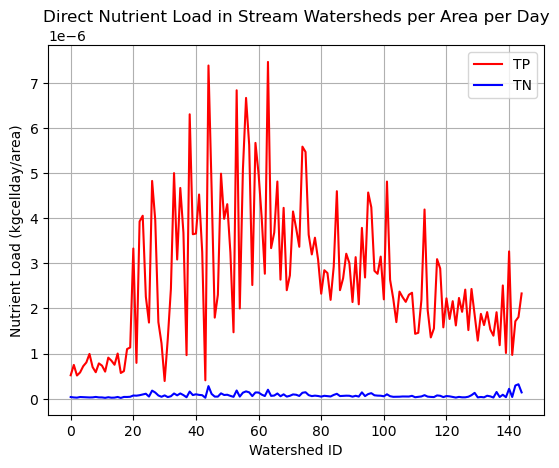

In [28]:
#dfZonalTP_watershed
# add a line to calculate the ratio of TN/TP

dfZonalTN_watershed[fieldDirectTN].plot(color='red', label='TP')
dfZonalTP_watershed[fieldDirectTP].plot(color='blue', label='TN')
plt.xlabel('Watershed ID')
plt.ylabel('Nutrient Load (kgcellday/area)')
plt.title('Direct Nutrient Load in Stream Watersheds per Area per Day')
plt.grid()
plt.legend()
plt.show()

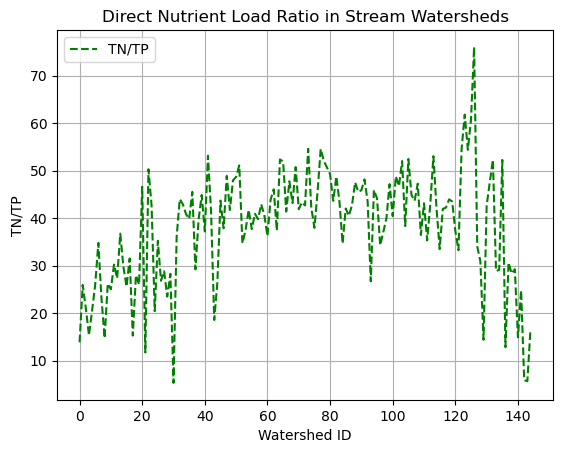

In [65]:
# Calcaulte the ratio of TN/TP for the direct delivery to watersheds and add it to dfWatershed then plot it
dfWatershed[fieldDirectRatio] = dfWatershed[fieldDirectTN]/dfWatershed[fieldDirectTP]
dfWatershed[fieldDirectRatio].plot(color='green', label='TN/TP', linestyle='--')
plt.xlabel('Watershed ID')
plt.ylabel('TN/TP')
plt.title('Direct Nutrient Load Ratio in Stream Watersheds')
plt.grid()
plt.legend()
plt.show()

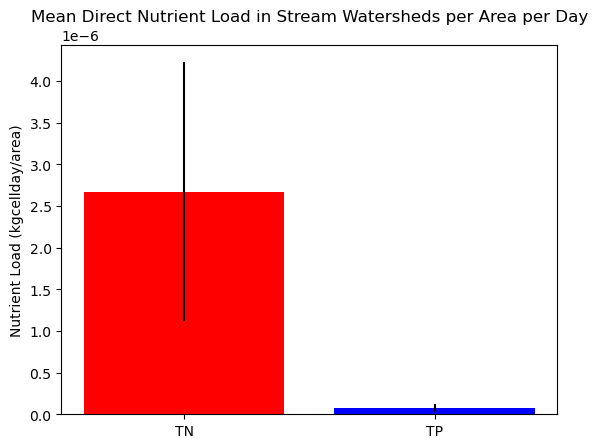

In [71]:
# Calculate mean and standard error for fieldDirectTN and fieldDirectTP and fieldDirectRatio 
# plot a column graph with error bars for the mean and standard error for each field
mean_directTN = dfWatershed[fieldDirectTN].mean()
std_directTN = dfWatershed[fieldDirectTN].std()

mean_directTP = dfWatershed[fieldDirectTP].mean()
std_directTP = dfWatershed[fieldDirectTP].std()



fig, ax = plt.subplots()
ax.bar(['TN', 'TP'], [mean_directTN, mean_directTP,], yerr=[std_directTN, std_directTP],color = ['red', 'blue'])
plt.ylabel('Nutrient Load (kgcellday/area)')

plt.title('Mean Direct Nutrient Load in Stream Watersheds per Area per Day')
plt.show()


## Plot Direct Nutrient Load to Coastal Watersheds

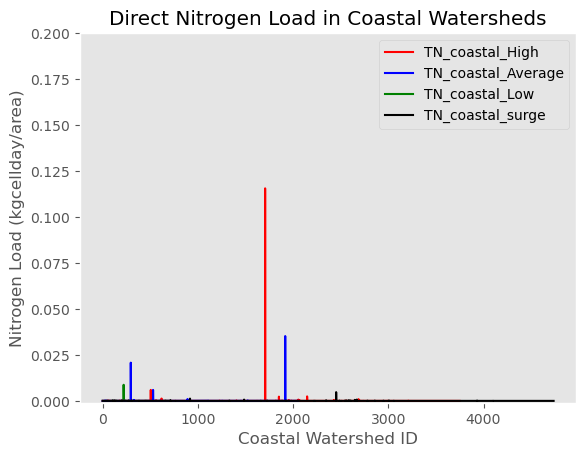

In [82]:
dfCoastalWatershed_high[fieldCoastalTN_high].plot(color='red', label='TN_coastal_High')
dfCoastalWatershed_avg[fieldCoastalTN_avg].plot(color='blue', label='TN_coastal_Average',zorder=2)
dfCoastalWatershed_low[fieldCoastalTN_low].plot(color='green', label='TN_coastal_Low', zorder=1)
dfCoastalWatershed_surge[fieldCoastalTN_surge].plot(color='black', label='TN_coastal_surge', zorder=3)
plt.xlabel('Coastal Watershed ID')
plt.ylabel('Nitrogen Load (kgcellday/area)')
plt.ylim(-0.001, 0.2)
plt.style.use('ggplot')

plt.title('Direct Nitrogen Load in Coastal Watersheds')

plt.grid()
plt.legend()
filename = 'Nitrogen_Load_in_Coastal_Watersheds.png'
outputname = os.path.join(outFig, filename)
plt.savefig(outputname)

## boxplot

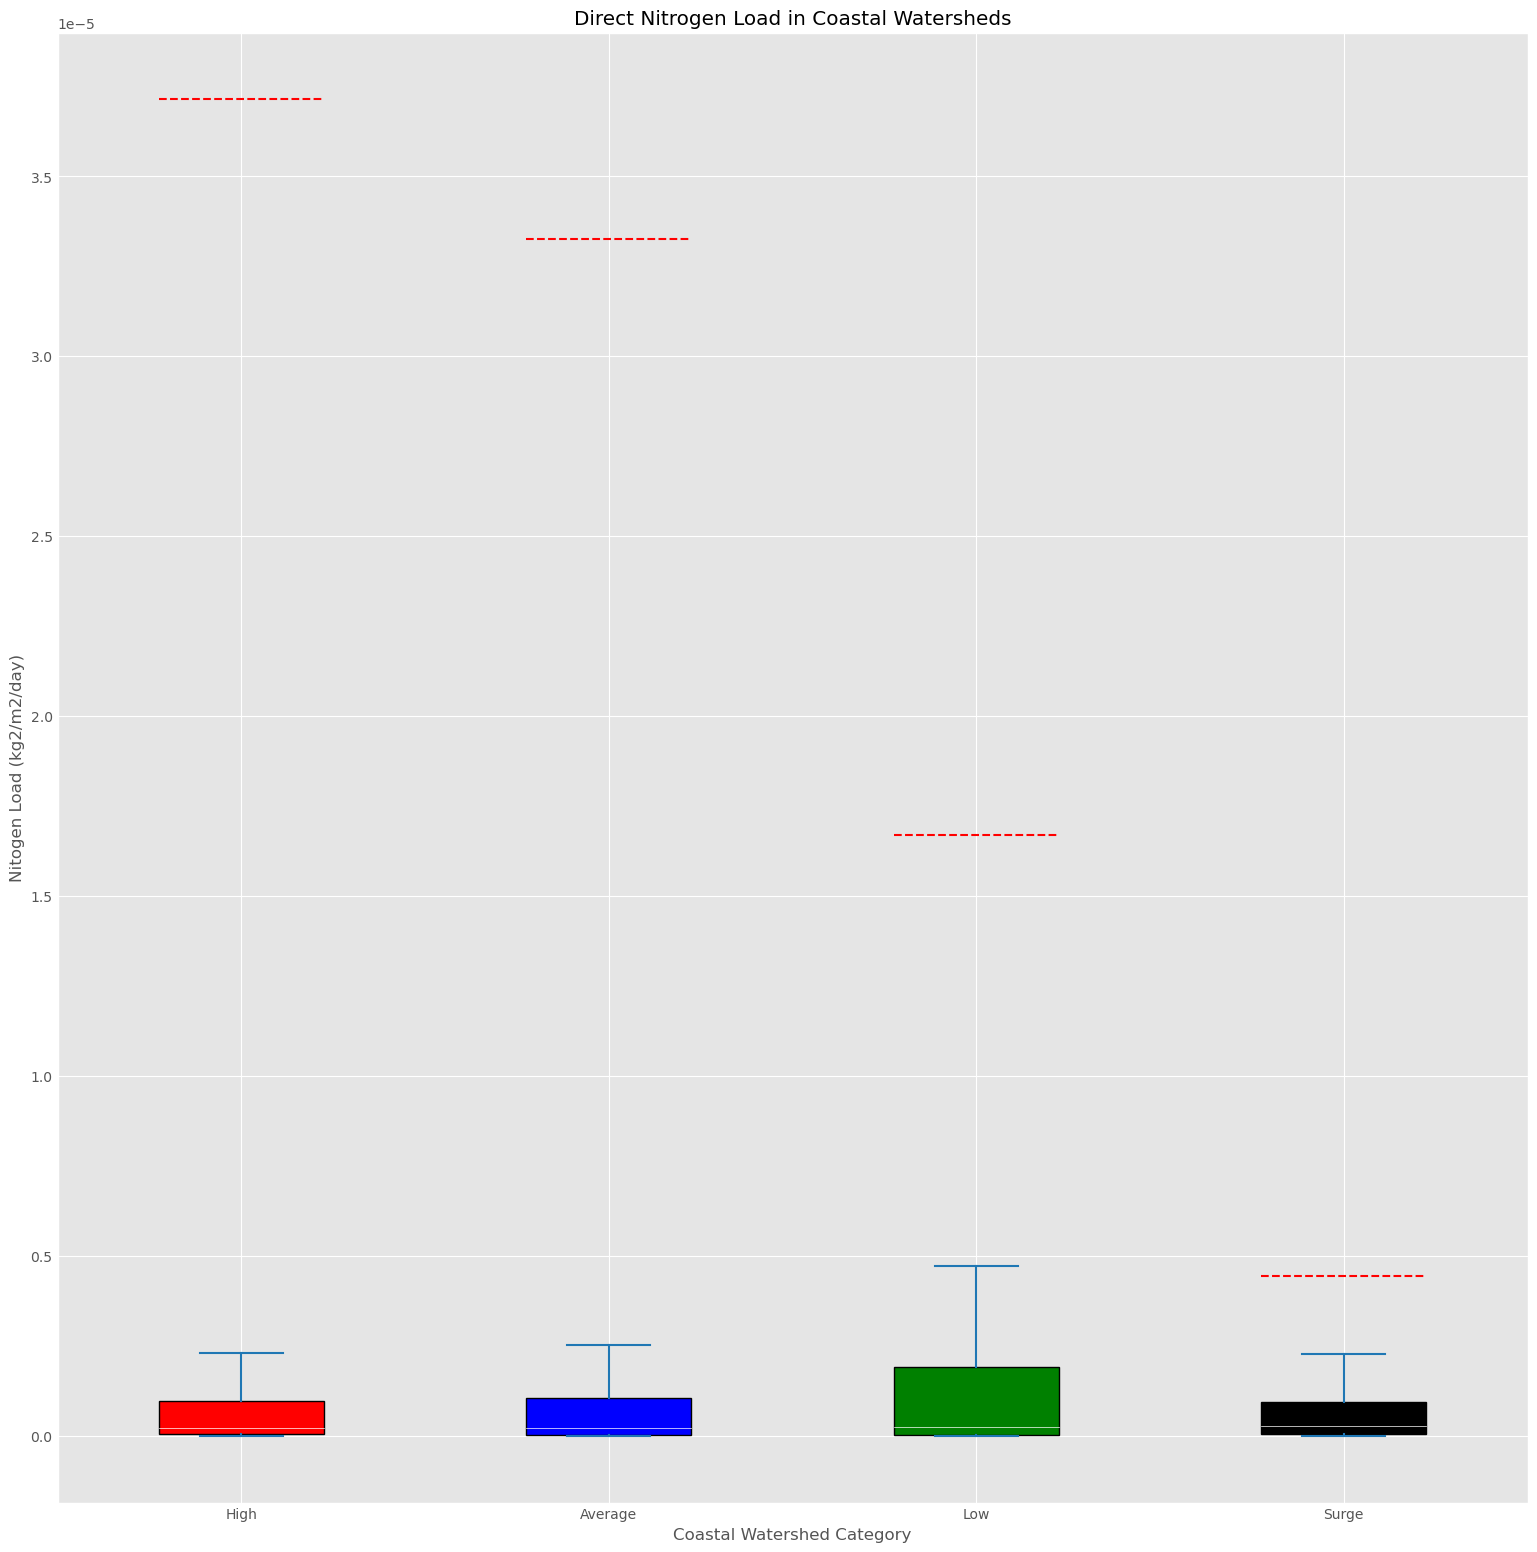

In [84]:
# Apply the '_mpl-gallery' style
plt.style.use('_mpl-gallery')

# Prepare the data for the box plot
data_N = [
    dfCoastalWatershed_high[fieldCoastalTN_high],
    dfCoastalWatershed_avg[fieldCoastalTN_avg],
    dfCoastalWatershed_low[fieldCoastalTN_low],
    dfCoastalWatershed_surge[fieldCoastalTN_surge]
]
# Calculate the mean and standard deviation for each category
means = [d.mean() for d in data_N]
stds = [d.std() for d in data_N]

# Plot the box plot with means and standard deviations
fig, ax = plt.subplots(figsize=(15, 15))
box = ax.boxplot(data_N, labels=['High', 'Average', 'Low', 'Surge'], patch_artist=True, showmeans=True, meanline=True,
                 medianprops={"color": "white", "linewidth": 0.5},
                 whiskerprops={"color": "C0", "linewidth": 1.5},
                 capprops={"color": "C0", "linewidth": 1.5},
                 meanprops={"color": "red", "linewidth": 1.5},
                 showfliers=False)

# Set different colors for each box
colors = ['red', 'blue', 'green', 'black']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    
# Set labels and title
plt.xlabel('Coastal Watershed Category')
plt.ylabel('Nitogen Load (kg2/m2/day)')
plt.title('Direct Nitrogen Load in Coastal Watersheds')

filename = 'Nitrogen_Load_in_Coastal_Watersheds_boxplot.png'
output_path = os.path.join(outFig, filename)
plt.savefig(output_path, dpi= 300)
plt.show()

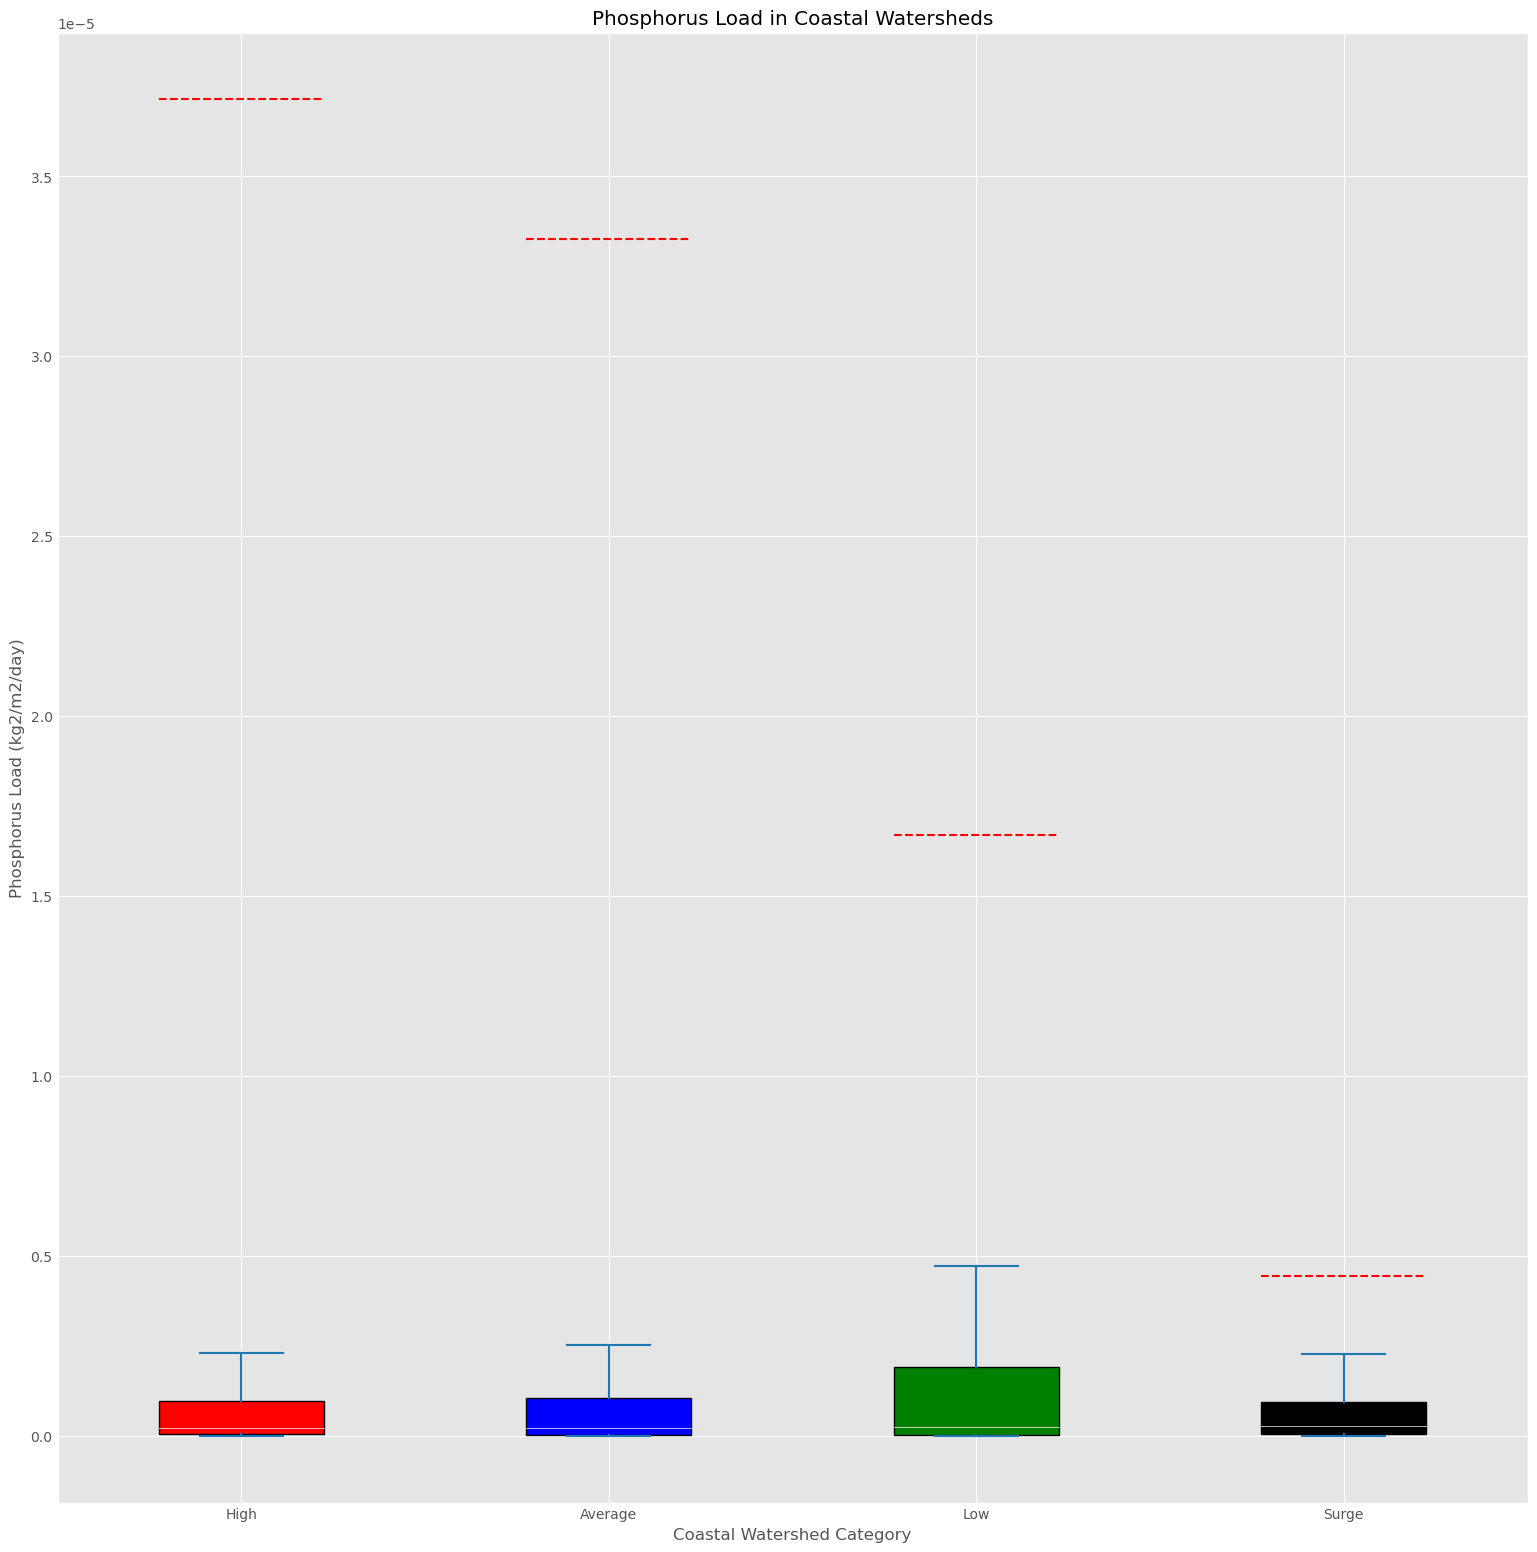

In [87]:
# Apply the '_mpl-gallery' style
plt.style.use('_mpl-gallery')

# Prepare the data for the box plot
data_P = [
    dfCoastalWatershed_high[fieldCoastalTP_high],
    dfCoastalWatershed_avg[fieldCoastalTP_avg],
    dfCoastalWatershed_low[fieldCoastalTP_low],
    dfCoastalWatershed_surge[fieldCoastalTP_surge]
]
# Plot
# Calculate the mean and standard deviation for each category
means = [d.mean() for d in data_N]
stds = [d.std() for d in data_N]

# Plot the box plot with means and standard deviations
fig, ax = plt.subplots(figsize=(15, 15))
box = ax.boxplot(data_P, labels=['High', 'Average', 'Low', 'Surge'], patch_artist=True, showmeans=True, meanline=True,
                 medianprops={"color": "white", "linewidth": 0.5},
                 whiskerprops={"color": "C0", "linewidth": 1.5},
                 capprops={"color": "C0", "linewidth": 1.5},
                 meanprops={"color": "red", "linewidth": 1.5},
                 showfliers=False)

# Set different colors for each box
colors = ['red', 'blue', 'green', 'black']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# Set labels and title
plt.xlabel('Coastal Watershed Category')
plt.ylabel('Phosphorus Load (kg2/m2/day)')
plt.title('Phosphorus Load in Coastal Watersheds')

filename = 'Phosphorus_Load_in_Coastal_Watersheds_boxplot.png'
output_path = os.path.join(outFig, filename)
plt.savefig(output_path, dpi= 300)
